In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pyxdf  # load file.xdf
import seaborn as sns
from scipy.signal import convolve2d # moving average
import os
import winsound
# interactive plots
%matplotlib widget 

In [23]:
# Keyboard input
# ask the user for 3 keyboad inputs : 1) subject group, 2) subject number, 3) experiment type

winsound.Beep(440, 1000)
# 1) subject group
gp = int(input('Enter subject group [1,2,3,4]: '))
# 2) subject number
sub = int(input('Enter subject number [1,... 40]: '))
# 3) experiment type
exp = int(input('Enter experiment type [1=MIpre, 2=PO, 3=Mipost]: '))

Constants, Dictionary

In [24]:
# Montage file
MONTAGE = 'DATA/montage_perfect.csv'

# Experiment groups
DICT_GROUP = {1: 'Group_Realistic_Arm', 2: 'Group_Realistic_Arm_Tactile', 3: 'Group_Unrealistic_Arm', 4: 'Group_Unrealistic_Arm_Tactile'}

# Subject
if sub < 10:
    subject = 'sub-S0' + str(sub)
else:
    subject = 'sub-S' + str(sub)

# Experiment
DICT_EXPERIMENT = {1: 'MIpre', 2: 'PO', 3: 'MIpost'}

# data
data_path_name = 'DATA/' + DICT_GROUP[gp] + '/' + subject + '_' + DICT_EXPERIMENT[exp] + '.xdf'

# C channels list
C_CHANNELS = ['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2', 'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 'Cp4', 'Cp5', 'Cp6', 'Cpz']

# dict of corresponding conditions
DICT_CONDITIONS = {'Left': 2, 'Right': 5, 'Third': 8}

# Experimental variables
BANDPASS_CUTOFF_LOW = 1.5
BANDPASS_CUTOFF_HIGH = 40
TIME_OFFSET = -1
DURATION = 5
SAMPLE_RATE = 2000
RE_SAMPLE_RATE = 200
REJECTION_TH = 100e-6
A_MIN = 8
A_MAX = 13
B_MIN = 15
B_MAX =30
G_MIN = 30
G_MAX = 40
WINDOW_SIZE = 0.5
WINDOW_STEP = 0.1

In [25]:
def get_index_of_stream_type(streams, stream_type):
    """
    Return the index of the stream with the given type.
    param: streams: list of streams
    param: stream_type: type of the stream (e.g. 'EEGDATA', 'POMARKER', 'MIMARKERTIME', 'MIMARKERCOND')
    return: data of the stream with the given type
    """
    chose_with = 'nothing'

    if stream_type == 'EEG': 
        chose_with = 'type'
        type = 'EEG'
        print("EEG data is being loaded")

    elif stream_type == 'MIMARKERTIME':
        chose_with = 'type'
        type = 'Stream type marker'
        print("MI markers time are being loaded")
    
    elif stream_type == 'MIMARKERCOND':
        chose_with = 'type'
        type = 'Stream trial marker'
        print("MI markers condition are being loaded")

    elif stream_type == 'POMARKER':
        chose_with = 'name'
        type = 'Unity.Marker.TargetID'
        print("PO markers are being loaded")

    else:
        raise NameError(
            f"given type '{type}' is not an argument. Accepted types are 'EEG' and 'TargetID'"
        )

    for i in range(len(streams)):
        if streams[i]['info'][chose_with][0] == type:
            print("Stream found :"+str(i))
            return i
    
    raise NameError(
        "No stream with the given type was found"
    )

def filter_data(raw, low_cutoff=BANDPASS_CUTOFF_LOW, high_cutoff=BANDPASS_CUTOFF_HIGH, filter_type = 'both'):
    """
    Return the filtered data of the stream with the given type.
    param: raw: raw data of the stream with the given type
    param: low_cutoff: low cutoff frequency
    param: high_cutoff: high cutoff frequency
    param: filter_type: type of filter (e.g. 'bandpass', 'CAR', 'both')
    return: filtered data of the stream with the given type
    """
    if filter_type == 'bandpass' or filter_type == 'both':
        filtered = raw.copy().filter(low_cutoff, high_cutoff)
    elif filter_type == 'CAR' or filter_type == 'both':
        filtered, data_ref = mne.set_eeg_reference(raw, ref_channels = 'average', copy = True)
    else :
        raise NameError(f"given type '{filter_type}' is not an argument. Accepted types are 'bandpass', 'CAR' and 'both'")
    return filtered

def get_raw_data(streams, montage):
    """
    Return the raw data of the stream with the given type.
    param: streams: list of streams
    param: montage: montage file
    param: bad_channels: list of bad channels (to be excluded)
    param: scalings: scaling factor for the data
    return: raw data of the stream with the given type (bandpass filtered)
    """
    stream_type = 'EEG'
    stream_index = get_index_of_stream_type(streams, stream_type)
    stream = streams[stream_index]['time_series'].T * 1e-6 # convert from uV to V (mne uses V)
    sfreq = float(streams[stream_index]['info']['nominal_srate'][0])
    ch_types = ['eeg'] * 64 + ['misc'] + ['bio']
    montage_label = pd.read_csv(montage)
    channel_label = montage_label['ch_name'].tolist()
    channel_label.append('Trigger')
    channel_label.append('GSR')
    info_passive = mne.create_info(channel_label, sfreq, ch_types)
    raw_passive = mne.io.RawArray(stream, info_passive) 
    print("\n  \n  Raw data information \n \n ", raw_passive.info)
    raw_passive.info['bads'].extend(['M1', 'M2', 'Trigger', 'GSR']) ## always remove those ones
    raw_passive = filter_data(raw_passive, filter_type='bandpass')
    raw_passive.plot(scalings=0.00013); 
    raw_C_channels = raw_passive.copy().pick_channels(C_CHANNELS)
    raw_C_channels.plot(scalings=0.00013);
    return raw_passive

def get_montage(csv_file, scale_factor=0.095):
    """
    Get the montage of the EEG data
    :param csv_file: csv file with the montage
    :param scale_factor: scale factor for the montage
    :return: montage
    """
    df_montage = pd.read_csv(csv_file)
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(df_montage['ch_name'], df_montage[['x', 'y', 'z']].values*scale_factor)), coord_frame='head')
    # montage.plot();
    return montage

def interpolate_bad_channels(raw, montage, bad_channels=[]):
    """
    Interpolate bad channels
    :param raw: raw data
    :param bad_channels: list of bad channels
    :return: raw data with interpolated bad channels
    """
    if bad_channels != []:
        raw.info['bads'].extend(bad_channels)
        raw.set_montage(montage)
        print("Interpolating channels: ", raw.info['bads'], "exclude M1, M2, Trigger")
        raw_interp = raw.copy().interpolate_bads(exclude=['M1', 'M2', 'Trigger'])
        raw_interp.plot(scalings=0.00013); 
        # print list of interpolated channels
        return raw_interp
    else:
        print("No bad channels to interpolate")
        return raw

def get_epochs(streams, raw, exp_block, time_offset=TIME_OFFSET, duration=DURATION, c_channels_only=True):
    """
    Return the epochs of the stream with the given type.
    param: streams: list of streams
    param: raw: raw data of the stream with the given type
    param: exp_block: type of experiment (e.g. 'MIpre', 'PO', 'MIpost')
    param: time_offset: time offset
    param: duration: duration
    return: epochs of the stream with the given type
    """

    Eeg = get_index_of_stream_type(streams, stream_type='EEG')
    t_origin = streams[Eeg]['time_stamps'][0]

    if exp_block == 'MIpre' or exp_block == 'MIpost':
        Markers_cond = get_index_of_stream_type(streams, stream_type='MIMARKERCOND')
        target_nb = np.array(streams[Markers_cond]['time_series']).squeeze()  # array with target IDs
        Markers_time = get_index_of_stream_type(streams, stream_type='MIMARKERTIME')
        time_stamps = streams[Markers_time]['time_stamps']
        # print(time_stamps)

        # first one correspond to the start of the first block, 2 sec before first MI trial
        # 90th one correspond to the start of the second block, 2 sec before first MI trial
        # then 30 trials per block of 2-5-2 sec so every start is separated by 9 sec
        t0_1 = time_stamps[0] - t_origin + 2
        ts1 = np.array([t0_1 + 9 * i for i in range(30)])
        t0_2 = time_stamps[90] - t_origin + 2
        ts2 = np.array([t0_2 + 9 * i for i in range(30)])
        time_stamps = np.concatenate((ts1, ts2))

        # WILL WORK AFTER UPDATE OF MI CODE TOBI
        # # take only one value each three (because of the three repetitions) starting with the second one
        # time_stamps = time_stamps[1::3] - t_origin  # signal begins at 0s
        
        # get the target ID for each trial
        df_target_nb = pd.DataFrame(target_nb, columns=['target_nb'])
        # replace the values of the dataframe with the corresponding target number in the dictionary CONDITIONS
        df_target_nb.replace({'target_nb': DICT_CONDITIONS}, inplace=True)
        target_nb = df_target_nb['target_nb'].values

        # print(time_stamps)

    elif exp_block == 'PO':
        Markers = get_index_of_stream_type(streams, stream_type='POMARKER')
        target_nb = np.array(streams[Markers]['time_series']).squeeze()  # array with target IDs
        time_stamps = streams[Markers]['time_stamps'] - t_origin  # signal begins at 0s

    else :
        raise NameError(f"given type '{exp_block}' is not an argument. Accepted types are 'MIpre', 'PO' and 'MIpost'")

    annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)  
    raw_annot = raw.copy().set_annotations(annots)
    events, event_ids = mne.events_from_annotations(raw_annot)
    if c_channels_only:
        raw = raw.pick_channels(C_CHANNELS)
        # Thus we reject epochs only based on the C channels !!
    epochs = mne.Epochs(raw, events, event_ids, tmin=time_offset, tmax=duration, baseline=(time_offset,0), reject=dict(eeg=REJECTION_TH), preload=True)  # bad channels won't appear on graph
    # print bad channels names
    print("Bad channels: ", epochs.info['bads'])

    epochs_cared = filter_data(epochs, filter_type='CAR')
    epochs_resampled = epochs_cared.resample(200)
    epochs_resampled['2'].plot(events=events, event_id=event_ids); 
    epochs_resampled['5'].plot(events=events, event_id=event_ids); 
    epochs_resampled['8'].plot(events=events, event_id=event_ids); 
    return epochs_resampled, events, event_ids

In [26]:
print('Data path: ' + data_path_name)
streams, header = pyxdf.load_xdf(data_path_name)

Data path: DATA/Group_Realistic_Arm/sub-S08_PO.xdf


Stream 6: Calculated effective sampling rate 612.1105 Hz is different from specified rate 999.9999 Hz.


EEG data is being loaded
Stream found :5
Creating RawArray with float64 data, n_channels=66, n_times=1629054
    Range : 0 ... 1629053 =      0.000 ...   814.527 secs
Ready.

  
  Raw data information 
 
  <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc, 1 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 2000.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished


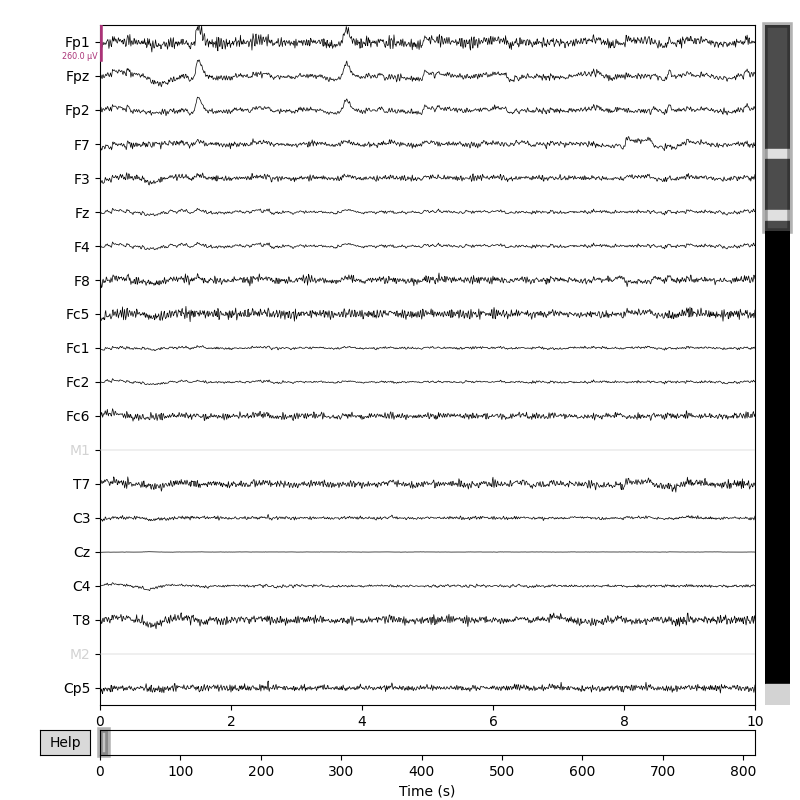

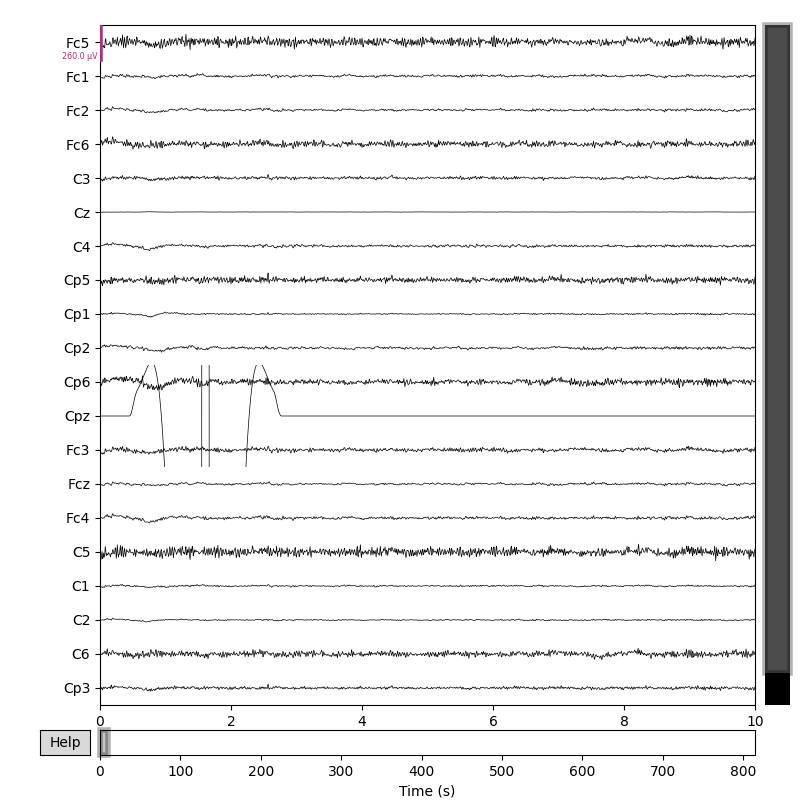

In [27]:
raw_data = get_raw_data(streams, MONTAGE)

In [28]:
# do a sound
winsound.Beep(440, 1000)
assert False
# TODO
# reject bad channels

AssertionError: 

In [ ]:
bad_channels = []
montage = get_montage(MONTAGE)
raw_data_interp = interpolate_bad_channels(raw_data, montage, bad_channels = bad_channels)

No bad channels to interpolate


EEG data is being loaded
Stream found :1
MI markers condition are being loaded
Stream found :0
MI markers time are being loaded
Stream found :2
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 12001 original time points ...
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
5 bad epochs dropped
Bad channels:  []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


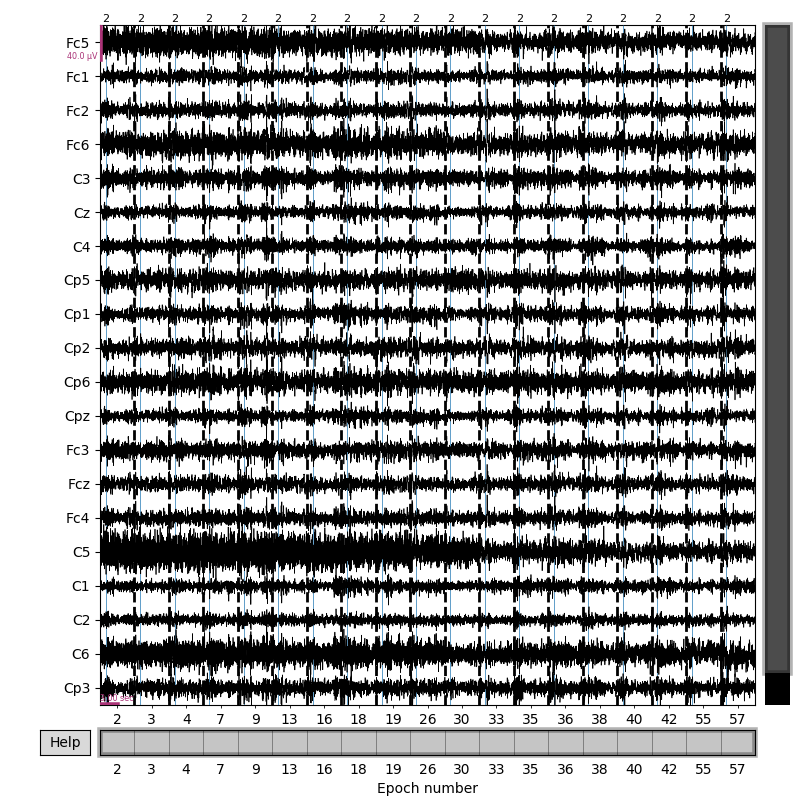

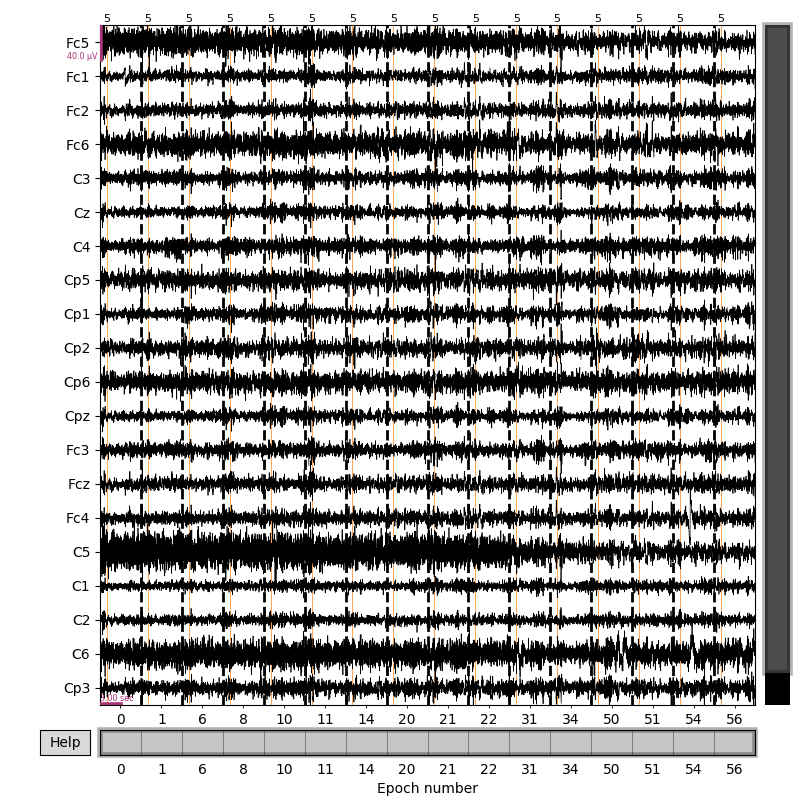

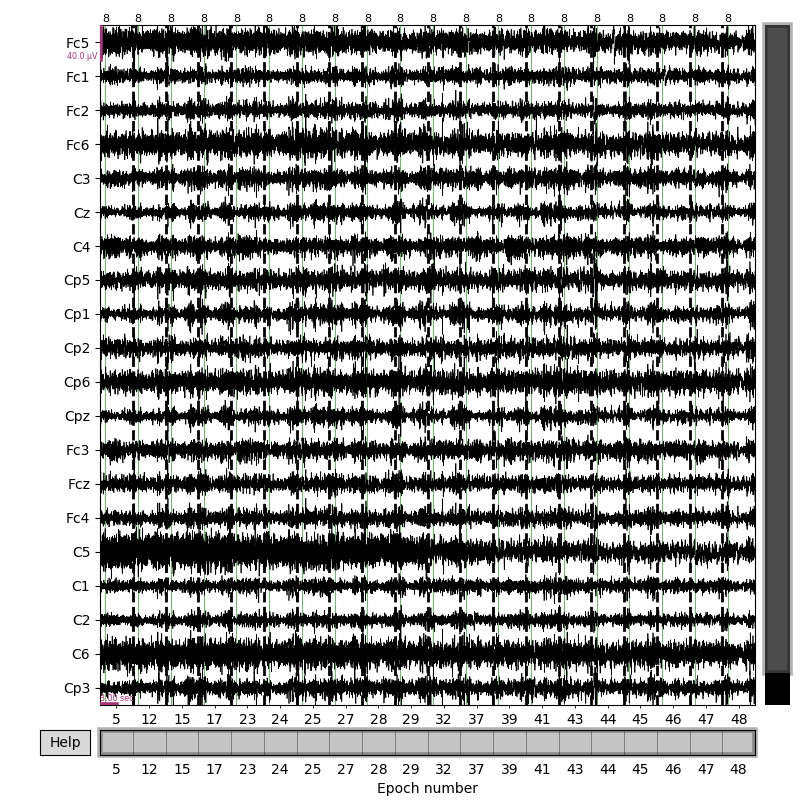

In [ ]:
# CAREFULL : if c_channels_only is default (True) we will only keep the C channels and only reject epochs BASED on C channels
epochs_resampled, events, event_ids = get_epochs(streams, raw=raw_data_interp, exp_block=DICT_EXPERIMENT[exp], time_offset=TIME_OFFSET, duration=DURATION)

In [ ]:
def extract_synchronisation_level(eeg_data, frequency_band):
    if frequency_band == 'alpha':
        fmin = A_MIN
        fmax = A_MAX
    elif frequency_band == 'beta':
        fmin = B_MIN
        fmax = B_MAX
    elif frequency_band == 'gamma':
        fmin = G_MIN
        fmax = G_MAX
    else:
        raise ValueError("frequency_band must be 'alpha', 'beta' or 'gamma'")
    eeg_data_filtered = eeg_data.copy().filter(l_freq=fmin, h_freq=fmax)
    return eeg_data_filtered

def epochs_to_dataframe(epochs_resampled):
    """
    Return the dataframe of the epochs.
    param: epochs_resampled: epochs of the stream with the given type
    return: dataframe of the epochs
    """    
    epochs_beta = extract_synchronisation_level(epochs_resampled, 'beta')
    epochs_alpha = extract_synchronisation_level(epochs_resampled, 'alpha')
    epochs_gamma = extract_synchronisation_level(epochs_resampled, 'gamma')
    df_alpha = epochs_alpha.to_data_frame()
    df_beta = epochs_beta.to_data_frame()
    df_gamma = epochs_gamma.to_data_frame()
    df = pd.concat([df_alpha, df_beta, df_gamma], keys=['alpha', 'beta', 'gamma'])
    df.reset_index(level = 0, inplace=True)
    df.rename(columns={'level_0': 'freq_band'}, inplace=True)
    return df

def calculate_power(df):
    """
    Calculate the power of each channel in a dataframe
    :param df: dataframe with EEG data
    :return: a dataframe with the power of each channel
    """
    df_power = df.copy()
    for channel in df_power.columns[4:]:
        df_power[channel] = df_power[channel].apply(lambda x: x ** 2)
    return df_power

def get_baseline(df):
    """
    Get the baseline of a dataframe
    :param df: dataframe with EEG data
    :return: a dataframe with the baseline of each channel
    """
    df_baseline = df[df['time'] < 0].groupby(['freq_band', 'condition', 'epoch']).mean()
    df_baseline.drop(columns=['time'], inplace=True)
    df_baseline.reset_index(inplace=True)
    # df_baseline = df_baseline.loc[df_baseline.index.repeat(df.shape[0])]
    return df_baseline

def normalization(df, baseline):
    """
    Normalize the power of each channel for each epoch by its corresponding baseline
    (for alpha and beta)
    """
    new_df = df.copy()
    for f in df['freq_band'].unique():
        for epoch in df['epoch'].unique():
            # data in all channels for f and epoch
            X = df.loc[(df['freq_band'] == f) & (df['epoch'] == epoch), df.columns[4:]].values
            b = baseline.loc[(baseline['freq_band'] == f) & (baseline['epoch'] == epoch), baseline.columns[3:]].values
            X_norm = (X - b) / b
            new_df.loc[(new_df['freq_band'] == f) & (new_df['epoch'] == epoch), new_df.columns[4:]] = X_norm
    return new_df


In [ ]:
df_epochs = epochs_to_dataframe(epochs_resampled)
df_power = calculate_power(df_epochs)
print(df_power.shape)

Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 177 samples (0.885 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.2s finished


(132000, 25)


In [ ]:
df_baseline = get_baseline(df_power)
df_norm = normalization(df_power, df_baseline)
print(df_norm.shape)

(132000, 25)


In [ ]:
def mooving_average2D(x, win, step):
    """
    Calculate the mooving average of a signal
    :param x: signal with shape (n_time, n_channels)
    :param win: window size (nb of samples)
    :param step: step size (nb of samples)
    :return: the mooving average of the signal
    """
    return convolve2d(x.T, np.ones((1,win))/win, 'valid').T[::step]

def moving_average_for_df(df, win, step, sp_freq):
    """
    Calculate the mooving average of a dataframe
    :param df: dataframe
    :param win: window size (sec)
    :param step: step size (sec)
    :return: the mooving average of the dataframe
    """
    win = int(win * sp_freq)
    step = int(step * sp_freq)
    df_ma = pd.DataFrame()
    df = df.copy()
    for f in df['freq_band'].unique():
        for epoch in df['epoch'].unique():
            # data in all channels for f and epoch
            X = df.loc[(df['freq_band'] == f) & (df['epoch'] == epoch), df.columns[4:]].values
            X_ma = mooving_average2D(X, win, step)
            df_X_ma = pd.DataFrame(X_ma)
            # add freq_band, time, condition and epoch columns
            df_X_ma.insert(0, 'freq_band', f)
            df_X_ma.insert(1, 'time', np.arange(0, X_ma.shape[0]) / (sp_freq / step) - 1) # begins at -1
            df_X_ma.insert(2, 'condition', df.loc[(df['freq_band'] == f) & (df['epoch'] == epoch), 'condition'].values[0])
            df_X_ma.insert(3, 'epoch', epoch)
            df_ma = pd.concat([df_ma, df_X_ma], ignore_index=True)
    # rename channels columns 
    df_ma.rename(columns={i: df.columns[i+4] for i in range(len(C_CHANNELS))}, inplace=True)
    return df_ma  

In [ ]:
df_ma = moving_average_for_df(df_norm, WINDOW_SIZE, WINDOW_STEP, RE_SAMPLE_RATE)
print(df_ma.shape)

(6160, 25)


In [ ]:
def plot_synch_per_channel_all_freq(df_percentage, condition):
    """Plot the level of synchronisation for a given condition per channel for both alpha and beta bands"""
    for channel in df_percentage.columns[3:]:
            df_alpha = df_percentage[(df_percentage['freq_band'] == 'alpha') & (df_percentage['condition'] == condition)]
            df_beta = df_percentage[(df_percentage['freq_band'] == 'beta') & (df_percentage['condition'] == condition)]
            sns.lineplot(data=df_alpha, x='time', y=channel, label = 'alpha')
            sns.lineplot(data=df_beta, x='time', y=channel, label = 'beta')
            plt.ylabel('Percentage of synchronisation')
            plt.xlabel('time [s]')
            #sns.lineplot(data=df_beta, x='window', y=channel, label = 'beta-band')
            plt.title(f'Level of synchronisation for channel {channel} for condition {condition} for alpha and beta band')
            plt.show()
            
def plot_synch_per_channel_all_cond(df_percentage, freq):
    """Plot the level of synchronisation for a given condition per channel for both alpha and beta bands"""
    for channel in df_percentage.columns[3:]:
            df_2 = df_percentage[(df_percentage['freq_band'] == freq) & (df_percentage['condition'] == '2')]
            df_5 = df_percentage[(df_percentage['freq_band'] == freq) & (df_percentage['condition'] == '5')]
            df_8 = df_percentage[(df_percentage['freq_band'] == freq) & (df_percentage['condition'] == '8')]
            sns.lineplot(data=df_2, x='time', y=channel, label = '2')
            sns.lineplot(data=df_5, x='time', y=channel, label = '5')
            sns.lineplot(data=df_8, x='time', y=channel, label = '8 (third)')
            plt.ylabel('Percentage of synchronisation')
            plt.xlabel('time [s]')
            #sns.lineplot(data=df_beta, x='window', y=channel, label = 'beta-band')
            plt.title(f'Level of synchronisation for channel {channel} across all conditions for {freq} band')
            plt.show()


def plot_synch_for_specific_channels(df_percentage, condition, channels):
    """Plot the level of synchronisation for a given condition for a set of channels for both alpha and beta bands in one plot"""
    for channel in channels:
        df_alpha = df_percentage[(df_percentage['freq_band'] == 'alpha') & (df_percentage['condition'] == condition)]
        df_beta = df_percentage[(df_percentage['freq_band'] == 'beta') & (df_percentage['condition'] == condition)]
        sns.lineplot(data=df_alpha, x='time', y=channel, label = channel + " (alpha-band)")
        sns.lineplot(data=df_beta, x='time', y=channel, label = channel + " (beta-band)")
        plt.ylabel('Percentage of synchronisation')
        plt.xlabel('time [s]')
        plt.title(f'Level of synchronisation for channels {channels} and condition {condition}')
        plt.show()
        
def plot_all_conditions_for_specific_channel(df_norm, channel):
    """Plot the level of synchronisation for a given channel for all condition and for both alpha and beta bands in one plot"""
    for condition in df_norm['condition'].unique():
        df_alpha = df_norm[(df_norm['freq_band'] == 'alpha') & (df_norm['condition'] == condition)]
        df_beta = df_norm[(df_norm['freq_band'] == 'beta') & (df_norm['condition'] == condition)]
        df_gamma = df_norm[(df_norm['freq_band'] == 'gamma') & (df_norm['condition'] == condition)]
        sns.lineplot(data=df_alpha, x='time', y=channel, label = condition + " (alpha-band)", ci = None)
        #plt.plot(df_alpha['time'], df_alpha[channel])
        #sns.lineplot(data=df_beta, x='time', y=channel, label = condition + " (beta-band)")
    plt.title(f'Level of synchronisation for channel {channel} across all conditions' )
    plt.ylabel('Percentage of synchronisation')
    plt.xlabel('time [s]')
    plt.show()

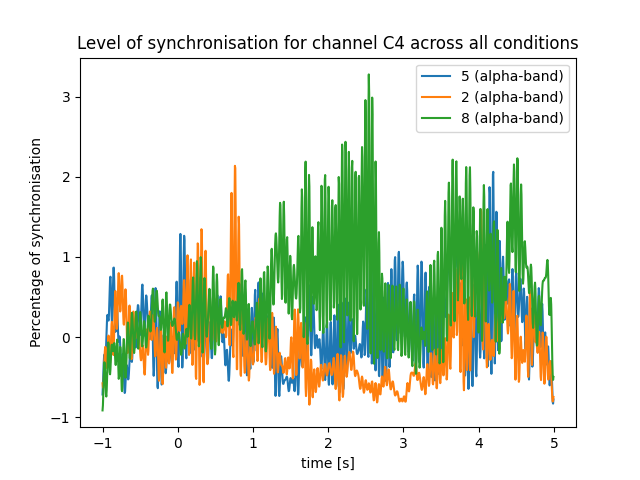

In [ ]:
plot_all_conditions_for_specific_channel(df_norm, 'C4')

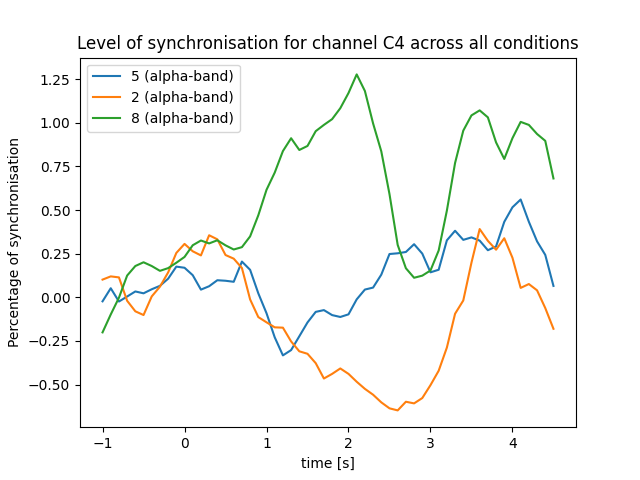

In [ ]:
plot_all_conditions_for_specific_channel(df_ma, 'C4')

In [ ]:
# do a sound
winsound.Beep(440, 1000)
assert False
# TODO
# save as csv

AssertionError: 

In [ ]:
# make list into a string of comma separated values
def list_to_string(list):
    string = ''
    for i in range(len(list)):
        string = string + str(list[i])
        if i < len(list) - 1:
            string = string + ','
    return string

def write_recap_csv(file_path_name, overwrite = False):
    # recap values for this run
    recap_dict = {'subject' : subject, 'group' : DICT_GROUP[gp], 'experience' : DICT_EXPERIMENT[exp], 'bandpass[Hz]' : str(BANDPASS_CUTOFF_LOW)+'-'+str(BANDPASS_CUTOFF_HIGH), \
    'nb_channels_used' : len(C_CHANNELS), 'channel_names' : list_to_string(C_CHANNELS), 'nb_channels_interpolated' : len(bad_channels), 'channel_names_interpolated' : list_to_string(bad_channels), \
    'nb_Epochs' : len(df_ma['epoch'].unique()), 'nb_Epochs_Right' : len(df_ma[df_ma['condition'] == '5']['epoch'].unique()), 'nb_Epochs_Left' : len(df_ma[df_ma['condition'] == '2']['epoch'].unique()), 'nb_Epochs_Third' : len(df_ma[df_ma['condition'] == '8']['epoch'].unique()), 'rejection_threshold[uV]' : REJECTION_TH, 'nb_Epochs_rejected' : 60-len(df_ma['epoch'].unique()), \
    'Epoch_tstart[s]' : TIME_OFFSET, 'Epoch_tend[s]' : DURATION, 'baseline_tstart[s]' : TIME_OFFSET, 'baseline_tend[s]' : 0, 'stimulation_tstart[s]' : 0, 'stimulation_tend[s]' : DURATION, \
    'EEG_reference' : 'CAR', 'original_sampling_rate[Hz]' : SAMPLE_RATE, 'resampled_sampling_rate[Hz]' : RE_SAMPLE_RATE, 'alpha_band' : str(A_MIN)+'-'+str(A_MAX), 'beta_band' : str(B_MIN)+'-'+str(B_MAX), 'gamma_band' : str(G_MIN)+'_'+str(G_MAX), \
    'normalization' : '%baseline', 'smoothing' : 'moving_average', 'window_size[s]' : WINDOW_SIZE, 'step_size[s]' : WINDOW_STEP, 'effective_duration[s]' : df_ma['time'].unique().max(), 'file_loc' : file_path_name}
    # check if DATA/recap.csv exists
    if os.path.exists('DATA/recap.csv'):
        # if it exists, read it
        df_recap = pd.read_csv('DATA/recap.csv', index_col=0)
    else:
        # if it does not exist, create it
        columns = list(recap_dict.keys())
        df_recap = pd.DataFrame(columns=columns)
    # check if subject with same experiment already exists
    if len(df_recap[(df_recap['subject'] == subject) & (df_recap['experience'] == DICT_EXPERIMENT[exp])]) > 0:
        # drop existing row fo subject and experiment
        print('Subject already exists, overwriting')
        df_recap.drop(df_recap.loc[(df_recap['subject'] == subject) & (df_recap['experience'] == DICT_EXPERIMENT[exp])].index, inplace=True)
    df_recap = df_recap.append(recap_dict, ignore_index=True)
    # order the rows by subject and experiment and reset index
    df_recap = df_recap.sort_values(by=['subject', 'experience']).reset_index(drop=True)
    df_recap.to_csv('DATA/recap.csv')

In [ ]:
# dataframe to save in csv
df_ml = df_ma[df_ma['time'] >= 0]

# file path name
folder_path_name = 'DATA/' + DICT_GROUP[gp] + '/' + 'preprocessed_data_folder/'
file_path_name = folder_path_name + subject + '_' + DICT_EXPERIMENT[exp] + '.csv'

# if folder does not exist, create it
if not os.path.exists(folder_path_name):
    os.makedirs(folder_path_name)
    print('folder created')

# if file does not exist, create it
if not os.path.exists(file_path_name):
    print('Saving preprocessed data to file: ', file_path_name)
    df_ml.to_csv(file_path_name, index=False)
    write_recap_csv(file_path_name)
    winsound.Beep(440, 1000)
else:
    winsound.Beep(440, 1000)
    print('File already exists: ', file_path_name)
    print('Do you want to overwrite it?')
    overwrite = input('y/n: ')
    if overwrite == 'y':
        print('Overwriting file: ', file_path_name)
        df_ml.to_csv(file_path_name, index=False)
        write_recap_csv(file_path_name)
    else:
        print('File & recap not overwritten')
    winsound.Beep(440, 1000)

Saving preprocessed data to file:  DATA/Group_Realistic_Arm/preprocessed_data_folder/sub-S08_MIpre.csv


In [ ]:
df_recap = pd.read_csv('DATA/recap.csv', index_col=0)
df_recap

,subject,group,experience,bandpass[Hz],nb_channels_used,channel_names,nb_channels_interpolated,channel_names_interpolated,nb_Epochs,nb_Epochs_Right,...,original_sampling_rate[Hz],resampled_sampling_rate[Hz],alpha_band,beta_band,normalization,smoothing,window_size[s],step_size[s],effective_duration[s],file_loc
0,sub-S01,Group_Realistic_Arm,MIpost,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",1,Fc5,55,19,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
1,sub-S01,Group_Realistic_Arm,MIpre,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",1,Fc5,58,19,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
2,sub-S02,Group_Realistic_Arm,MIpost,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",3,"Cpz,Fc2,Fc4",45,14,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
3,sub-S02,Group_Realistic_Arm,MIpre,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",3,"Cpz,Fc2,Fc4",56,19,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
4,sub-S02,Group_Realistic_Arm,PO,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",3,"Cpz,Fc2,Fc4",55,18,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
5,sub-S03,Group_Realistic_Arm,MIpost,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",0,NaN,56,18,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
6,sub-S03,Group_Realistic_Arm,MIpre,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",0,NaN,57,20,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
7,sub-S03,Group_Realistic_Arm,PO,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",0,NaN,56,17,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
8,sub-S04,Group_Realistic_Arm,MIpost,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",0,NaN,59,20,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
9,sub-S04,Group_Realistic_Arm,MIpre,1.5-40,21,"C1,C2,C3,Cz,C4,C5,C6,Fc1,Fc2,Fc3,Fcz,Fc4,Fc5,F...",0,NaN,59,20,...,2000,200,8-13,15-30,%baseline,moving_average,0.5,0.1,4.5,DATA/Group_Realistic_Arm/preprocessed_data_fol...
